In [8]:
from pipeline import (univariate_data_analysis, load_data, split_data, optimize_model, #compare_models,
split_univariate_sequence, objective, time_series_forecasting, prepare_data_for_optimization, create_optuna_model)
import pandas as pd

# First we load the data

In [9]:
df_filtered, df_info_filtered = load_data()

Info Filtered:
       M4id category  Frequency  Horizon      SP    StartingDate
99623   H38    Other         24       48  Hourly  01-07-15 12:00
99649   H64    Other         24       48  Hourly  01-07-15 12:00
99813  H228    Other         24       48  Hourly  15-05-10 12:00
99860  H275    Other         24       48  Hourly  02-01-10 12:00
99989  H404    Other         24       48  Hourly  06-01-17 12:00

Filtered Data (First Rows):
V1 Step  H404  H275     H64  H228     H38
0    V2  27.0  15.3  2777.0  12.4  3648.0
1    V3  22.0  15.0  2886.0  11.7  3658.0
2    V4  25.0  14.7  2811.0  11.1  3608.0
3    V5  25.0  14.4  2648.0  10.7  3493.0
4    V6  14.0  14.3  2618.0  10.3  3374.0


In [10]:
def index_date(ts):
    starting_date = df_info_filtered[df_info_filtered['M4id'] == ts]['StartingDate'].iloc[0]
    date_range = pd.date_range(start=starting_date, periods=len(df_filtered[ts]), freq='H')
    df_filtered[ts].index = date_range
    return df_filtered[ts].dropna()

ts = index_date('H228')

# Then we explore the series, with distribution, the ACF, PACF, moving avg, decomposition and descriptive statistics

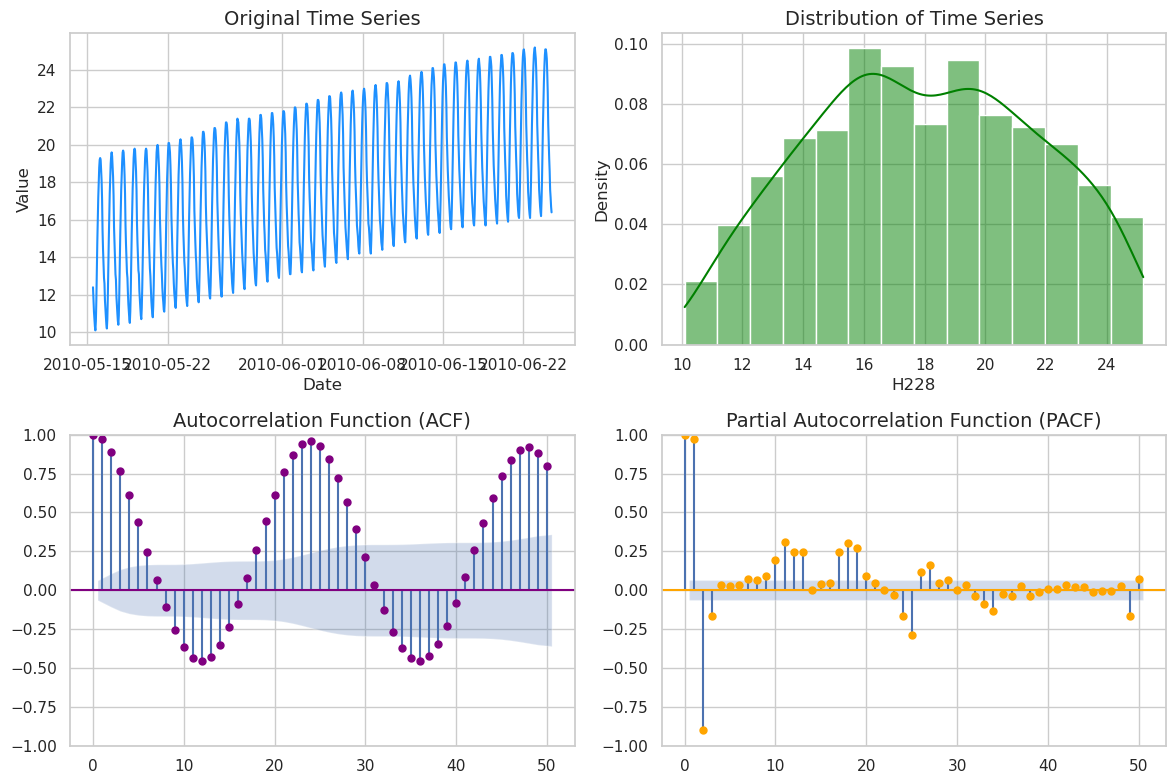

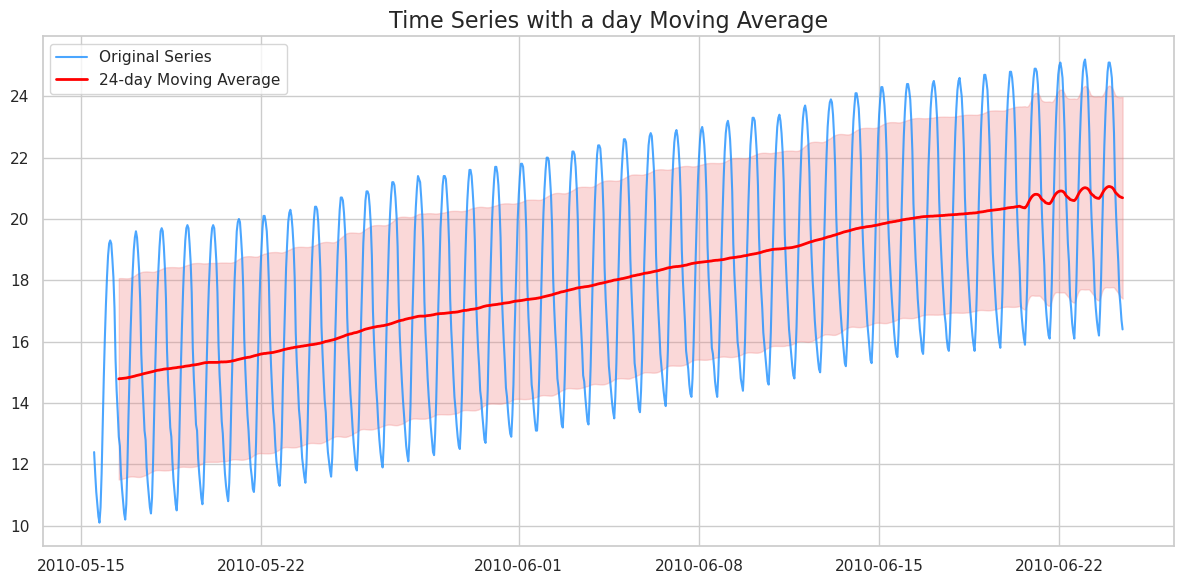

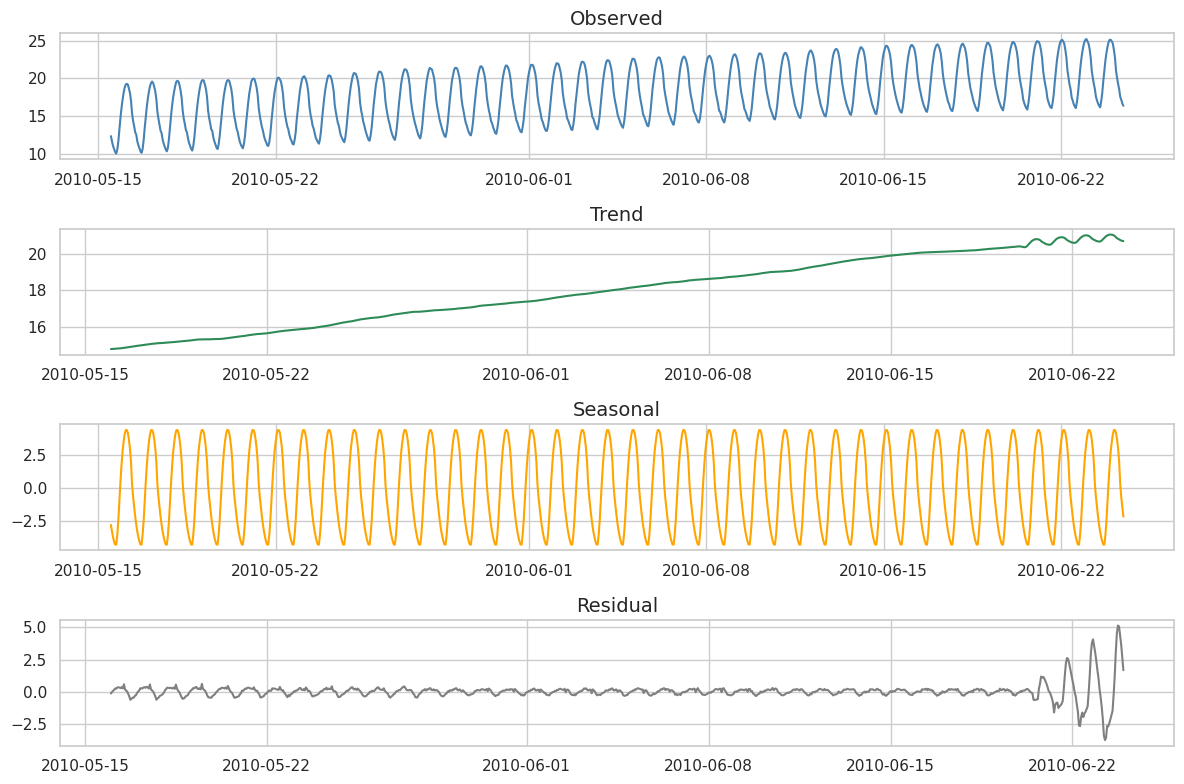

Descriptive Statistics:
count    960.000000
mean      17.977396
std        3.711648
min       10.100000
25%       15.200000
50%       17.900000
75%       20.900000
max       25.200000
Name: H228, dtype: float64

Shapiro-Wilk Test p-value: 1.2973477847566528e-10
Interpretation: p < 0.05 suggests the data is not normally distributed

Augmented Dickey-Fuller Test for Stationarity:
ADF Statistic: -1.1984878942287127
p-value: 0.6742458431630435
Interpretation:
p < 0.05: Reject null hypothesis (Series is stationary)
p >= 0.05: Fail to reject null hypothesis (Series might be non-stationary)


In [11]:
univariate_data_analysis(ts)

- **Distribution:**  
  The histogram appears like **bimodal** and not normal with a mean around 17.98, suggesting as in the previous ts, multiple states, also the Shapiro-Wilk sugests no normaility

- **Autocorrelation:**  
  A clear pattern emerges **every 24 hours**, reinforcing the fact that the series exhibits **daily seasonality**.  

- **Partial Autocorrelation:**  
  Significant spikes at the **first and second lags** indicate a **strong autoregressive component**. This means that **previous observations** have a **major impact** on the next ones.  

- **ADF Test:**  
  The test suggests that the series is **non-stationary**, aligning with the **seasonal patterns** previously observed.  

- **Moving Average Analysis:**  
  The daily moving average captures the underlying trend while smoothing out the daily fluctuations, showing a consistent upward trend.


# Then We Split the Data and Model  

The `time_series_forecasting` function applies a **Min-Max scaling transformation** to help the model converge faster. It then:  

1. **Creates daily sequences**  
2. **Reshapes the data** for each specific architecture  
3. **Trains 12 different architectures** (3 per model) with **early stopping** for 200 epochs  
4. **Selects the best model** based on the lowest **MAE**  
5. **Plots its predictions** and comparisons with the test data  

This ensures we find the most effective model for the given time series data.  


Train: 624, Validation: 144, Test: 144


/home/pepechuy/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/pepechuy/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/pepechuy/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
MLP Model 1 MAE: 0.3813366285959875
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/steppWARNING:tensorflow:5 out of the last 57 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x70acf2923b00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
MLP Model 2 MAE: 0.7893845431009929
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MLP Model 3 MAE: 0.41081060250600143
4/4 ━━━━━━━━━━━━━

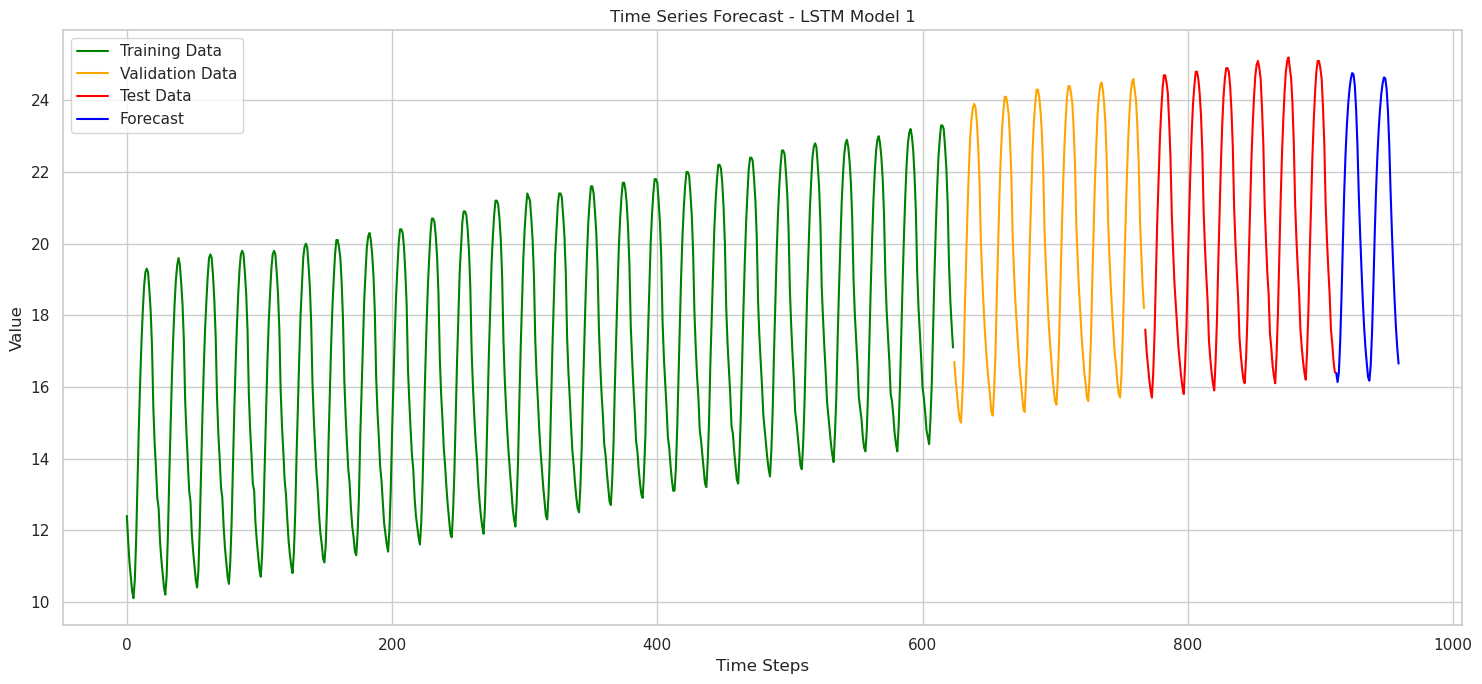

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


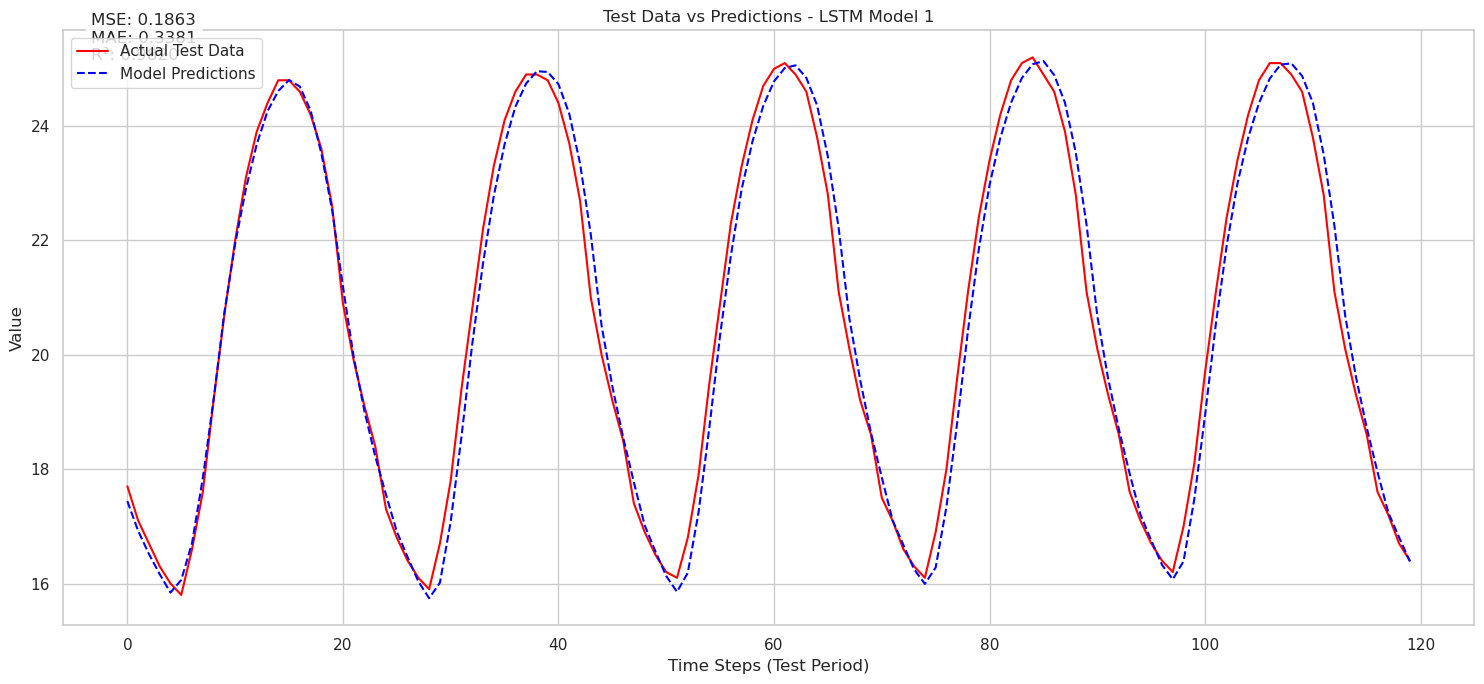


Model Performance Comparison:
      Model Type  Mean Absolute Error
    LSTM Model 1             0.338055
     MLP Model 1             0.381337
     CNN Model 1             0.387052
     MLP Model 3             0.410811
CNN-LSTM Model 1             0.456027
CNN-LSTM Model 3             0.467897
    LSTM Model 3             0.472588
CNN-LSTM Model 2             0.536413
     CNN Model 2             0.575238
    LSTM Model 2             0.747662
     MLP Model 2             0.789385
     CNN Model 3             3.209434


In [13]:
train_data, val_data, test_data = split_data(ts)
best_model = time_series_forecasting(train_data, val_data, test_data)

The best model was a single **LSTM** with:
- **1 LSTM layer** with **50 neurons**
- **1 Dense output layer** with **1 neuron**
- **Activation function:** ReLU

In [ ]:
best_model['best_model'].summary()

Model: "sequential_207"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_688 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

# Optuna

After that, we select the model that gave the best results and optimize it with **Optuna** for:  
- **Learning rate**  
- **Activation functions**  
- **Number of layers**  
- **Number of units per layer**  
- **Optimizer**  

The function is designed to **adapt** and tune the best model architecture **regardless of its type**, as different models can perform better depending on the series. Our goal is to achieve the **optimal performance** possible.  

The experiment runs for **100 trials**, then the results are **de-scaled** and plotted against the **test set**, allowing us to compare with the previous model.  


In [ ]:
result = optimize_model(train_data, val_data, test_data, n_steps=24, model_type='mlp', n_trials=200)
best_model = result['best_model']
best_params = result['best_params']
scaler = result['scaler']

[I 2025-04-03 00:11:19,511] A new study created in memory with name: no-name-f4bdf6b6-231d-4172-94ae-136320f09649
/home/pepechuy/Downloads/School/Sexto Semestre/nolineales/Examen2/Examen2NL/pipeline.py:690: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
/home/pepechuy/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-04-03 00:11:23,572] Trial 0 finished with value: 0.024856917560100555 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.002796749456876363, 'activation': 'e

## Best MLP Model Optimization Results - Improved Model

### Summary
- **Number of trials:** 200
- **Best trial value (MAE):** 0.004735623020678759
- **Best hyperparameters:**  
  - **Optimizer:** Adam  
  - **Learning rate:** 0.0008420183450492546  
  - **Activation:** ELU  
  - **Number of layers:** 2  
  - **Neurons per layer:**  
    - **Layer 0:** 169  
    - **Layer 1:** 126  
  - **Dropout (Layer 1):** 9.97854530457433e-05  


We achieved a **0.0047 MAE**, which indicates a stunning model outperforming by far the previous model which wasnt even bad
